In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import numpy as np
import seaborn.objects as so

In [2]:
def read_merged_df():
    sub_dfs = []
    for typ in ("default", "combined", "all"):
        sub_df = pd.read_csv(
            f"{typ}_settings.csv",
            index_col=["dim", "impl", "H", "W", "D"],
        )
        sub_df["typ"] = typ
        sub_dfs.append(sub_df)
    df1 = sub_dfs[0].set_index("typ", append=True).sort_index()
    df2 = sub_dfs[1].set_index("typ", append=True).sort_index()
    df3 = sub_dfs[2].set_index("typ", append=True).sort_index()
    # print(df.groupby(["direction", "prec", "impl", "num_data_points"])["kernel_cycles"].idxmin())
    # print(df.shape)
    df1 = df1.loc[
        df1.groupby(["dim", "impl", "num_data_points"])["kernel_cycles"].idxmin()
    ]
    df2 = df2.loc[
        df2.groupby(["dim", "impl", "num_data_points"])["kernel_cycles"].idxmin()
    ]
    df3 = df3.loc[
        df3.groupby(["dim", "impl", "num_data_points"])["kernel_cycles"].idxmin()
    ]
    # best_ci_df = best_ci_df[
    #     ~(
    #         (best_ci_df.index.get_level_values("prec") == 32)
    #         & (best_ci_df.index.get_level_values("C") % 2 == 1)
    #     )
    # ]
    # roofline_df = pd.concat([df.assign(tag='cur'), prev_df.assign(tag='prev')]).reset_index()
    return (
        df1.reset_index().sort_values(
            ["impl", "dim", "num_data_points"]
        ).reset_index(drop=True),
        df2.reset_index().sort_values(
            ["stride", "impl", "dim", "num_data_points"]
        ).reset_index(drop=True),
        df3.reset_index().sort_values(
            ["stride", "impl", "dim", "num_data_points"]
        ).reset_index(drop=True))

(df, df_c, df_a) = read_merged_df()
df_all = df.copy()
df = df[(df["impl"] == "Multicore Optimized") | (df["dim"] == "1D")]

In [3]:
def plot_result(y_col, df, ticks=[], labels=[]):
    hue = list(df.reset_index()[["dim", "impl"]].apply(lambda tup: f"{tup["dim"]} {tup["impl"][10:]}", axis=1))
    # print(df)
    g = sns.lineplot(data=df, x="num_data_points", y=y_col, hue=hue, marker="o")
    g.set_xscale("log", base=2)
    if len(labels) > 0:
        g.set(xticks=ticks, xticklabels=labels)

    # g.set_xscale("log", base=2)

    g.set_xlabel("Input Matrix Size (H x W x D), N=1, C=8")
    g.get_legend().set_title("Implementation")
    g.grid()
    return g

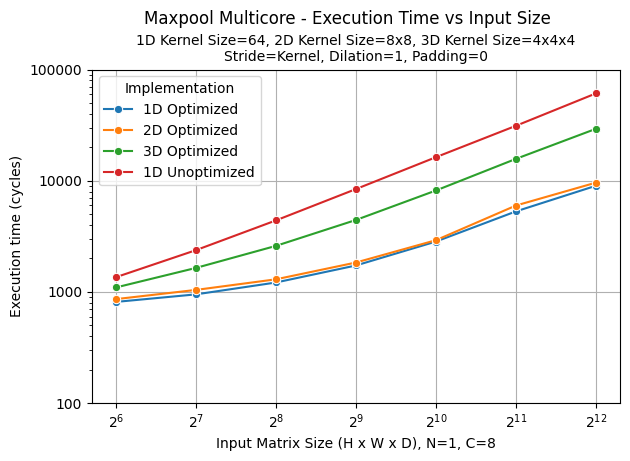

In [4]:
g = plot_result("kernel_cycles", df)
g.set_yscale("log", base=10)
g.set_ylabel("Execution time (cycles)")
g.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

title = "Maxpool Multicore - Execution Time vs Input Size"
subtitle = "1D Kernel Size=64, 2D Kernel Size=8x8, 3D Kernel Size=4x4x4\nStride=Kernel, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_ylim(100, 100000)
plt.tight_layout()
plt.savefig("plots/kernel_cycles_stride64.png")
plt.show()

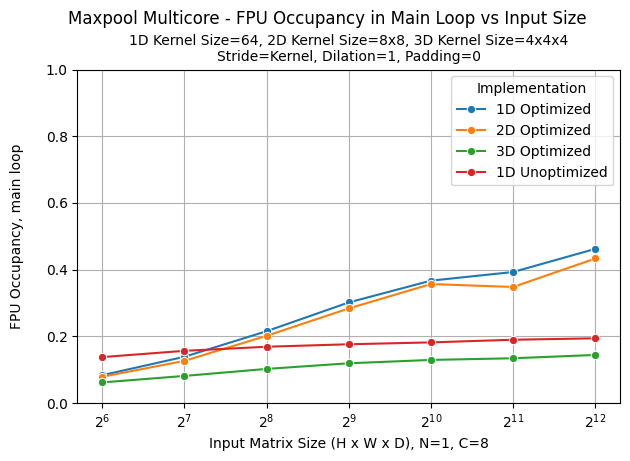

In [5]:
g = plot_result("fpss_fpu_occupancy", df)

g.set_ylabel("FPU Occupancy, main loop\n")

title = "Maxpool Multicore - FPU Occupancy in Main Loop vs Input Size"
subtitle = "1D Kernel Size=64, 2D Kernel Size=8x8, 3D Kernel Size=4x4x4\nStride=Kernel, Dilation=1, Padding=0"

plt.suptitle(title, x=0.52, y=0.95, fontsize=12)

g.set_title(subtitle, fontsize=10)

g.set_ylim(0, 1.0)
plt.tight_layout()
plt.savefig("plots/fpu_occupancy_stride64.png")
plt.show()

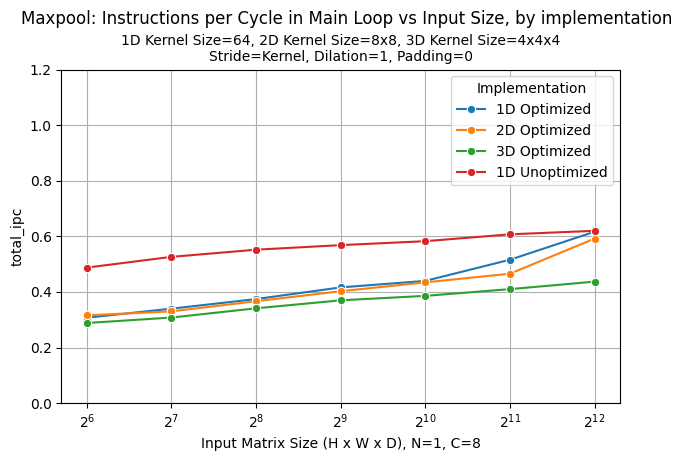

In [6]:
g = plot_result("total_ipc", df)

title = "Maxpool: Instructions per Cycle in Main Loop vs Input Size, by implementation"
subtitle = "1D Kernel Size=64, 2D Kernel Size=8x8, 3D Kernel Size=4x4x4\nStride=Kernel, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_ylim(0, 1.2)
plt.tight_layout()
plt.savefig("plots/main_loop_ipc.png")
plt.show()

In [7]:
peak_flops = 8
peak_bandwidth = 64

impl_to_work_stride1 = {
    ("1D", 64): 504,
    ("2D", 64): 504,
    ("3D", 64): 504,
    ("1D", 128): 32760,
    ("2D", 128): 4536,
    ("3D", 128): 2520,
    ("1D", 256): 97272,
    ("2D", 256): 40824,
    ("3D", 256): 12600,
    ("1D", 512): 226296,
    ("2D", 512): 113400,
    ("3D", 512): 63000,
}

dim_to_kernel = {
    "1D": "64",
    "2D": "8x8",
    "3D": "4x4x4",
}

def get_augmented_df(df, filter=True):
    roofline_df = df.copy()
    roofline_df = roofline_df[(roofline_df["stride"] != 1) | (roofline_df["num_data_points"] != 64)] if filter else roofline_df
    work = df[["dim", "impl", "stride", "num_data_points"]].apply(
        lambda tup: tup["num_data_points"] / 64 * 63 * 8 if (tup["stride"] == 64) else impl_to_work_stride1[(tup["dim"], tup["num_data_points"])],
        axis=1,
    )
    # print(work)
    data_movement = roofline_df[["dim", "impl", "num_data_points"]].apply(
        lambda tup: tup["num_data_points"] * 8 * 8,
        axis=1,
    )
    # print(data_movement)
    roofline_df["work"] = work
    roofline_df["op_intensity"] = work / data_movement
    roofline_df["performance"] = work / roofline_df["kernel_cycles"]
    return roofline_df

def build_roofline(df, dim):
    roofline_df = df[df["dim"] == dim]
    # roofline_df["direction"] = direction
    # roofline_df = df.sort_values(["dim", "impl", "num_data_points"])
    # print(roofline_df)
    roofline_df = get_augmented_df(roofline_df)
    hue = list(
        roofline_df[["dim", "impl", "stride"]].apply(
            lambda tup: f"{tup["dim"]} {tup["impl"][10:]}, Stride={tup["stride"]}", axis=1
        )
    )
    print(hue)
    style = list(
        roofline_df[["dim", "impl", "stride"]].apply(
            tuple, axis=1
        )
    )
    print(style)
    ax = sns.scatterplot(
        data=roofline_df,
        x="op_intensity",
        y="performance",
        hue=hue,
        marker="o"
    )
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    
    xlim_right = 10
    ax.set_xlim(1/16,xlim_right)
    ax.set_ylim(None, 16)

    # ax.plot([0, peak_flops / peak_bandwidth], [0, peak_flops], marker="", color="black")
    ax.plot(
        [peak_flops / peak_bandwidth, xlim_right],
        [peak_flops, peak_flops],
        marker="",
        color="black",
    )

    ax.plot(
        [0, peak_flops / peak_bandwidth],
        [0, peak_flops],
        marker="",
        color="black",
    )
    
    plt.text(xlim_right, peak_flops, "8 FLOPs/Cycle, FP64",
        horizontalalignment='right',
        verticalalignment='bottom',)

    ax.set_xlabel("Operational Intensity")
    ax.set_title(f"Maxpool {dim} Multicore - Roofline Model\nKernel Size={dim_to_kernel[dim]}, Dilation=1, Padding=0")
    return ax

['1D Optimized, Stride=1', '1D Optimized, Stride=1', '1D Optimized, Stride=1', '1D Unoptimized, Stride=1', '1D Unoptimized, Stride=1', '1D Unoptimized, Stride=1', '1D Optimized, Stride=64', '1D Optimized, Stride=64', '1D Optimized, Stride=64', '1D Optimized, Stride=64', '1D Optimized, Stride=64', '1D Optimized, Stride=64', '1D Optimized, Stride=64', '1D Unoptimized, Stride=64', '1D Unoptimized, Stride=64', '1D Unoptimized, Stride=64', '1D Unoptimized, Stride=64', '1D Unoptimized, Stride=64', '1D Unoptimized, Stride=64', '1D Unoptimized, Stride=64']
[('1D', 'Multicore Optimized', 1), ('1D', 'Multicore Optimized', 1), ('1D', 'Multicore Optimized', 1), ('1D', 'Multicore Unoptimized', 1), ('1D', 'Multicore Unoptimized', 1), ('1D', 'Multicore Unoptimized', 1), ('1D', 'Multicore Optimized', 64), ('1D', 'Multicore Optimized', 64), ('1D', 'Multicore Optimized', 64), ('1D', 'Multicore Optimized', 64), ('1D', 'Multicore Optimized', 64), ('1D', 'Multicore Optimized', 64), ('1D', 'Multicore Optimi

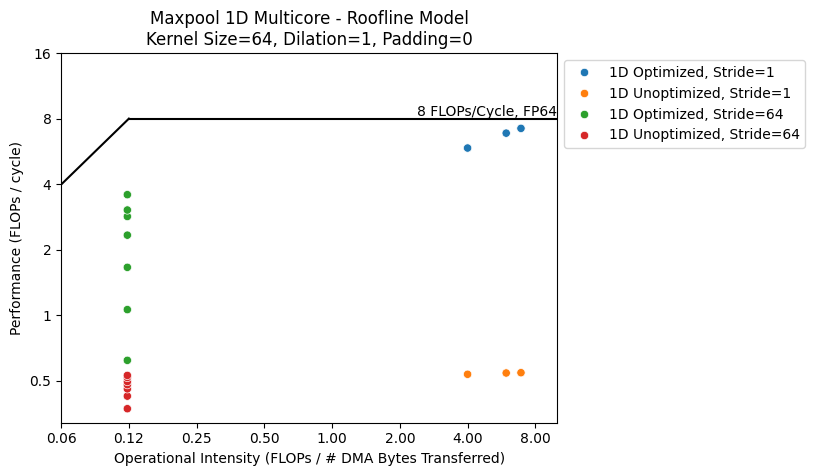

In [8]:
ax = build_roofline(df_c, "1D")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2g}"))
ax.set_ylabel("Performance (FLOPs / cycle)")
ax.set_xlabel("Operational Intensity (FLOPs / # DMA Bytes Transferred)")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("plots/roofline_1d.png", bbox_inches="tight")
plt.show()

['2D Optimized, Stride=1', '2D Optimized, Stride=1', '2D Optimized, Stride=1', '2D Unoptimized, Stride=1', '2D Unoptimized, Stride=1', '2D Unoptimized, Stride=1', '2D Optimized, Stride=64', '2D Optimized, Stride=64', '2D Optimized, Stride=64', '2D Optimized, Stride=64', '2D Optimized, Stride=64', '2D Optimized, Stride=64', '2D Optimized, Stride=64', '2D Unoptimized, Stride=64', '2D Unoptimized, Stride=64', '2D Unoptimized, Stride=64', '2D Unoptimized, Stride=64', '2D Unoptimized, Stride=64', '2D Unoptimized, Stride=64', '2D Unoptimized, Stride=64']
[('2D', 'Multicore Optimized', 1), ('2D', 'Multicore Optimized', 1), ('2D', 'Multicore Optimized', 1), ('2D', 'Multicore Unoptimized', 1), ('2D', 'Multicore Unoptimized', 1), ('2D', 'Multicore Unoptimized', 1), ('2D', 'Multicore Optimized', 64), ('2D', 'Multicore Optimized', 64), ('2D', 'Multicore Optimized', 64), ('2D', 'Multicore Optimized', 64), ('2D', 'Multicore Optimized', 64), ('2D', 'Multicore Optimized', 64), ('2D', 'Multicore Optimi

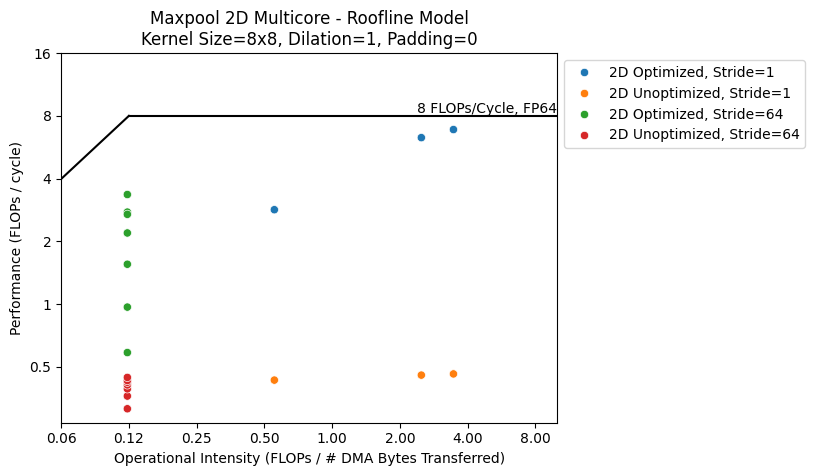

In [9]:
ax = build_roofline(df_c, "2D")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2g}"))
ax.set_ylabel("Performance (FLOPs / cycle)")
ax.set_xlabel("Operational Intensity (FLOPs / # DMA Bytes Transferred)")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("plots/roofline_2d.png", bbox_inches="tight")
plt.show()

['3D Optimized, Stride=1', '3D Optimized, Stride=1', '3D Optimized, Stride=1', '3D Unoptimized, Stride=1', '3D Unoptimized, Stride=1', '3D Unoptimized, Stride=1', '3D Optimized, Stride=64', '3D Optimized, Stride=64', '3D Optimized, Stride=64', '3D Optimized, Stride=64', '3D Optimized, Stride=64', '3D Optimized, Stride=64', '3D Optimized, Stride=64', '3D Unoptimized, Stride=64', '3D Unoptimized, Stride=64', '3D Unoptimized, Stride=64', '3D Unoptimized, Stride=64', '3D Unoptimized, Stride=64', '3D Unoptimized, Stride=64', '3D Unoptimized, Stride=64']
[('3D', 'Multicore Optimized', 1), ('3D', 'Multicore Optimized', 1), ('3D', 'Multicore Optimized', 1), ('3D', 'Multicore Unoptimized', 1), ('3D', 'Multicore Unoptimized', 1), ('3D', 'Multicore Unoptimized', 1), ('3D', 'Multicore Optimized', 64), ('3D', 'Multicore Optimized', 64), ('3D', 'Multicore Optimized', 64), ('3D', 'Multicore Optimized', 64), ('3D', 'Multicore Optimized', 64), ('3D', 'Multicore Optimized', 64), ('3D', 'Multicore Optimi

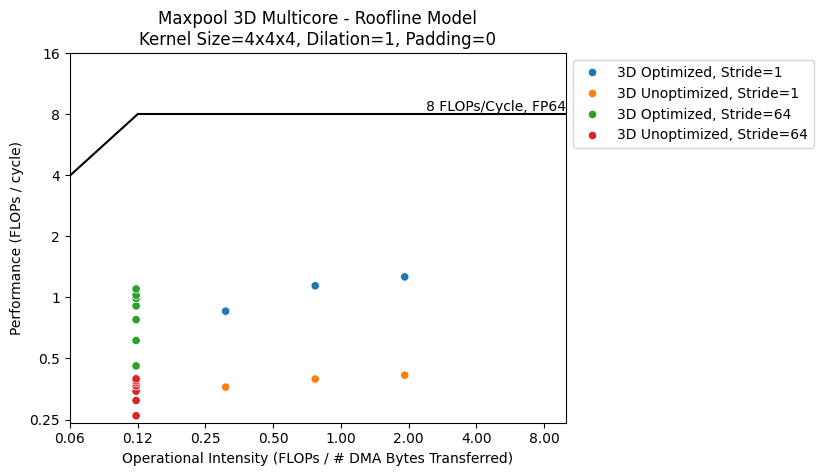

In [10]:
ax = build_roofline(df_c, "3D")

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2g}"))
ax.set_ylabel("Performance (FLOPs / cycle)")
ax.set_xlabel("Operational Intensity (FLOPs / # DMA Bytes Transferred)")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig("plots/roofline_3d.png", bbox_inches="tight")
plt.show()

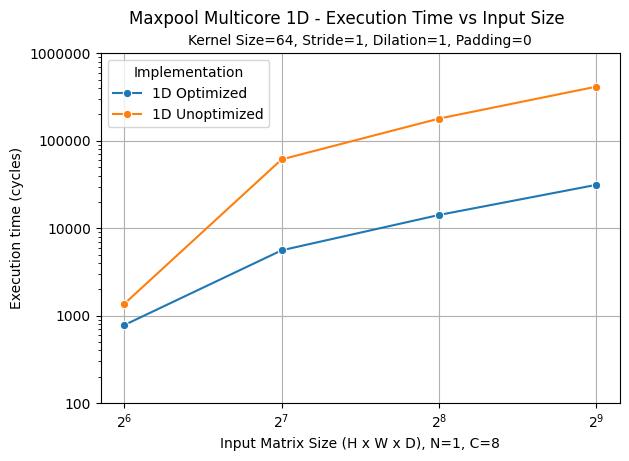

In [11]:
g = plot_result("kernel_cycles", df_a[(df_a["stride"] == 1) & (df_a["dim"] == "1D") & ((df_a["impl"] == "Multicore Optimized") | (df_a["impl"] == "Multicore Unoptimized"))])
g.set_yscale("log", base=10)
g.set_ylabel("Execution time (cycles)")
g.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

title = "Maxpool Multicore 1D - Execution Time vs Input Size"
subtitle = "Kernel Size=64, Stride=1, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_ylim(100, 1000000)
plt.tight_layout()
plt.savefig("plots/kernel_cycles_stride1_1d.png")
plt.show()

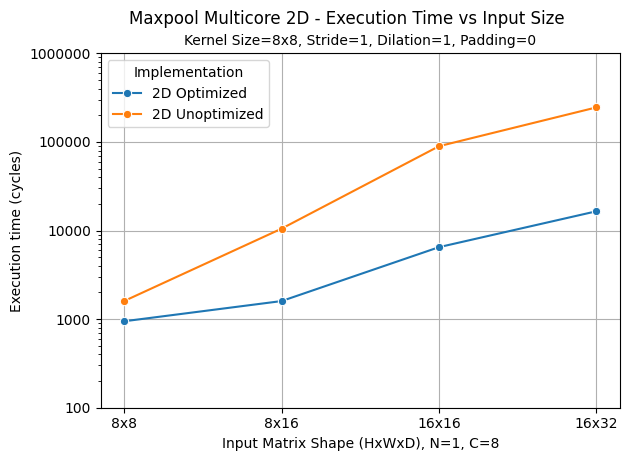

In [12]:
data = df_a[(df_a["stride"] == 1) & (df_a["dim"] == "2D") & ((df_a["impl"] == "Multicore Optimized") | (df_a["impl"] == "Multicore Unoptimized"))]
g = plot_result("kernel_cycles", data, ticks=[64, 128, 256, 512], labels=["8x8", "8x16", "16x16", "16x32"])
g.set_yscale("log", base=10)
g.set_ylabel("Execution time (cycles)")
g.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

title = "Maxpool Multicore 2D - Execution Time vs Input Size"
subtitle = "Kernel Size=8x8, Stride=1, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_xlabel("Input Matrix Shape (HxWxD), N=1, C=8")

g.set_ylim(100, 1000000)
plt.tight_layout()
plt.savefig("plots/kernel_cycles_stride1_2d.png")
plt.show()

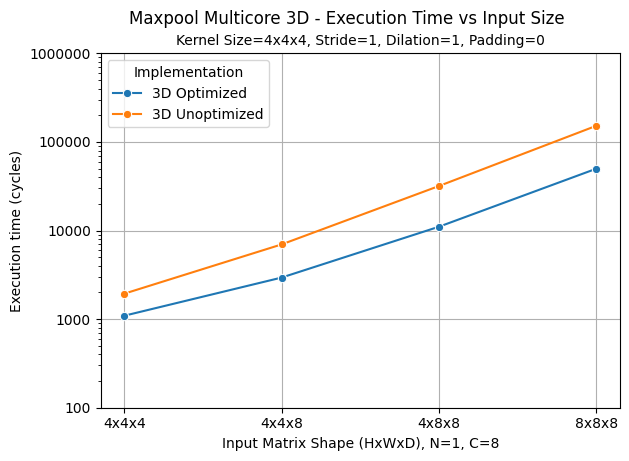

In [13]:
data = df_a[(df_a["stride"] == 1) & (df_a["dim"] == "3D") & ((df_a["impl"] == "Multicore Optimized") | (df_a["impl"] == "Multicore Unoptimized"))]
g = plot_result("kernel_cycles", data, ticks=[64, 128, 256, 512], labels=["4x4x4", "4x4x8", "4x8x8", "8x8x8"])
g.set_yscale("log", base=10)
g.set_ylabel("Execution time (cycles)")
g.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))

title = "Maxpool Multicore 3D - Execution Time vs Input Size"
subtitle = "Kernel Size=4x4x4, Stride=1, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_xlabel("Input Matrix Shape (HxWxD), N=1, C=8")

g.set_ylim(100, 1000000)
plt.tight_layout()
plt.savefig("plots/kernel_cycles_stride1_3d.png")
plt.show()

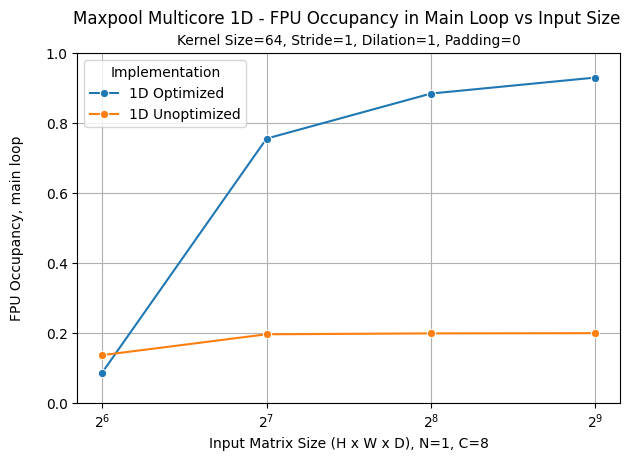

In [14]:
g = plot_result("fpss_fpu_occupancy", df_a[(df_a["stride"] == 1) & (df_a["dim"] == "1D") & ((df_a["impl"] == "Multicore Optimized") | (df_a["impl"] == "Multicore Unoptimized"))])

g.set_ylabel("FPU Occupancy, main loop\n")

title = "Maxpool Multicore 1D - FPU Occupancy in Main Loop vs Input Size"
subtitle = "Kernel Size=64, Stride=1, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_ylim(0, 1.0)
plt.tight_layout()
plt.savefig("plots/occ_stride1_1d.png")
plt.show()

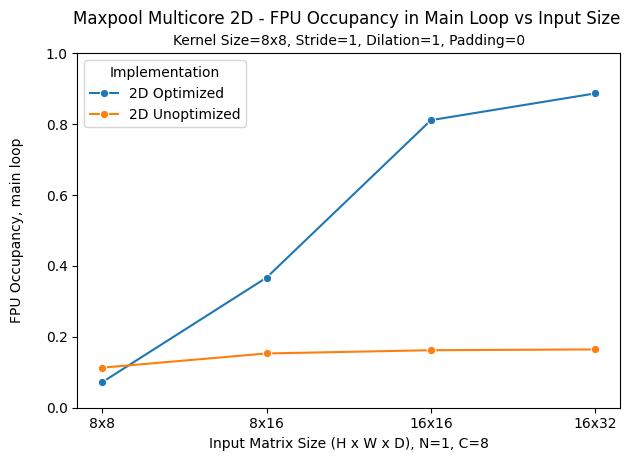

In [15]:
g = plot_result("fpss_fpu_occupancy",
                df_a[(df_a["stride"] == 1) & (df_a["dim"] == "2D") & ((df_a["impl"] == "Multicore Optimized") | (df_a["impl"] == "Multicore Unoptimized"))],
                ticks=[64, 128, 256, 512], labels=["8x8", "8x16", "16x16", "16x32"])

g.set_ylabel("FPU Occupancy, main loop\n")
# g.set_xlabel("Input Matrix Shape (HxW), N=1, C=8")
g.grid()

title = "Maxpool Multicore 2D - FPU Occupancy in Main Loop vs Input Size"
subtitle = "Kernel Size=8x8, Stride=1, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_ylim(0, 1.0)
plt.tight_layout()
plt.savefig("plots/occ_stride1_2d.png")
plt.show()

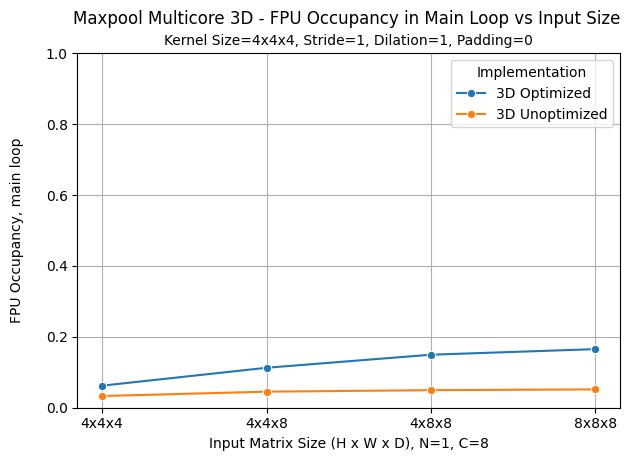

In [16]:
g = plot_result("fpss_fpu_occupancy",
                df_a[(df_a["stride"] == 1) & (df_a["dim"] == "3D") & ((df_a["impl"] == "Multicore Optimized") | (df_a["impl"] == "Multicore Unoptimized"))],
                ticks=[64, 128, 256, 512], labels=["4x4x4", "4x4x8", "4x8x8", "8x8x8"])

g.set_ylabel("FPU Occupancy, main loop\n")

title = "Maxpool Multicore 3D - FPU Occupancy in Main Loop vs Input Size"
subtitle = "Kernel Size=4x4x4, Stride=1, Dilation=1, Padding=0"

plt.suptitle(title, x=0.55, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_ylim(0, 1.0)
plt.tight_layout()
plt.savefig("plots/occ_stride1_3d.png")
plt.show()

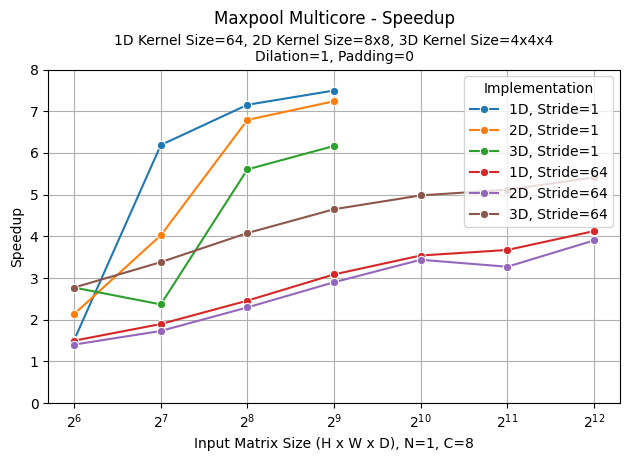

In [17]:
single_core = df_a[df_a["impl"] == "Singlecore Optimized"].set_index(["dim", "stride", "num_data_points"])
multicore = df_a[df_a["impl"] == "Multicore Optimized"].set_index(["dim", "stride", "num_data_points"])
sf = single_core["kernel_cycles"]/multicore["kernel_cycles"]
# df_div = pd.DataFrame({"key": df.index, "list": sf.values})
df_div = sf.to_frame()
# print(df_div)

hue = list(df_div.reset_index()[["dim", "stride"]].apply(lambda tup: f"{tup["dim"]}, Stride={tup["stride"]}", axis=1))

g = sns.lineplot(data=df_div, x="num_data_points", y="kernel_cycles", hue=hue, marker="o")
g.set_xscale("log", base=2)

title = "Maxpool Multicore - Speedup"
subtitle = "1D Kernel Size=64, 2D Kernel Size=8x8, 3D Kernel Size=4x4x4\nDilation=1, Padding=0"

plt.suptitle(title, x=0.53, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

g.set_xlabel("Input Matrix Size (H x W x D), N=1, C=8")
g.set_ylabel("Speedup")
g.set_ylim(0, 8)

g.get_legend().set_title("Implementation")
g.grid()

plt.tight_layout()
plt.savefig("plots/speedup_all.png")
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_22492\1115581259.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["fill", "8x8", "8x16", "16x16", "16x32", "32x32", "32x64", "64x64"])


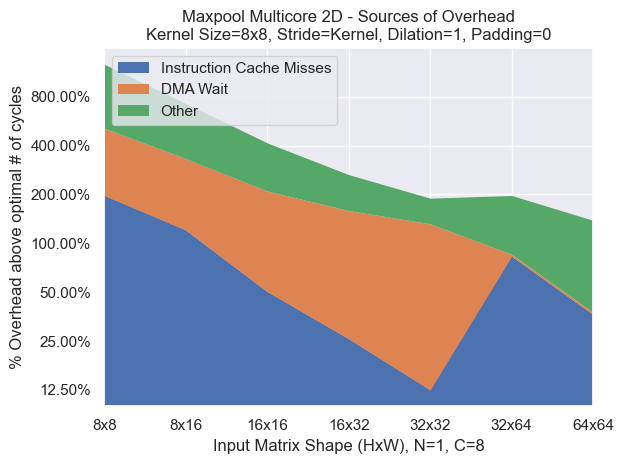

In [18]:
df_opt = df_a[(df_a["impl"] == "Multicore Optimized") & (df_a["stride"] == 64) & (df_a["dim"] == "2D")]
df_opt = get_augmented_df(df_opt, filter=False).dropna(axis=1)
df_opt["optimal_cycles"] = (df_opt["work"]/8)
df_opt["overhead_pct"] = df_opt["kernel_cycles"] / df_opt["optimal_cycles"]-1
df_opt["icache_overhead"] = df_opt["icache_miss"] / df_opt["optimal_cycles"]
df_opt["dma_overhead"] = df_opt["time_spent_waiting_in_barrier"] / df_opt["optimal_cycles"]
df_opt["rest"] = df_opt["overhead_pct"] - df_opt["icache_overhead"] - df_opt["dma_overhead"]

sns.set_theme()
ax = plt.gca()
plt.stackplot(df_opt["num_data_points"],
              df_opt["icache_overhead"], df_opt["dma_overhead"], df_opt["rest"],
              labels=["Instruction Cache Misses", "DMA Wait", "Other"],
              linewidth=0)

plt.legend(loc='upper left')
# ax.set_ylim(0.0001, None)
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.set_xticklabels(["fill", "8x8", "8x16", "16x16", "16x32", "32x32", "32x64", "64x64"])

ax.set_title("Maxpool Multicore 2D - Sources of Overhead\nKernel Size=8x8, Stride=Kernel, Dilation=1, Padding=0")
ax.set_ylabel("% Overhead above optimal # of cycles")
ax.set_xlabel("Input Matrix Shape (HxW), N=1, C=8")
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=2))

plt.margins(x=0)

plt.tight_layout()
plt.savefig("plots/overhead_2d_stride64.png")
plt.show()

sns.reset_defaults()

C:\Users\David\AppData\Local\Temp\ipykernel_22492\1310819650.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["fill", "4x4x4", "4x4x8", "4x8x8", "8x8x8", "8x8x16", "8x16x16", "16x16x16"])


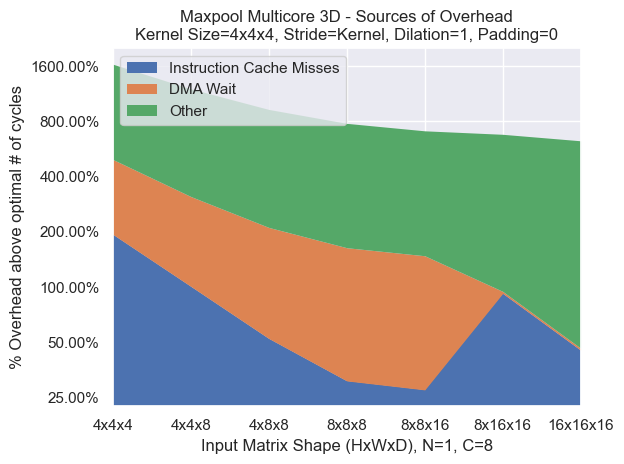

In [19]:
df_opt = df_a[(df_a["impl"] == "Multicore Optimized") & (df_a["stride"] == 64) & (df_a["dim"] == "3D")]
df_opt = get_augmented_df(df_opt, filter=False).dropna(axis=1)
df_opt["optimal_cycles"] = (df_opt["work"]/8)
df_opt["overhead_pct"] = df_opt["kernel_cycles"] / df_opt["optimal_cycles"]-1
df_opt["icache_overhead"] = df_opt["icache_miss"] / df_opt["optimal_cycles"]
df_opt["dma_overhead"] = df_opt["time_spent_waiting_in_barrier"] / df_opt["optimal_cycles"]
df_opt["rest"] = df_opt["overhead_pct"] - df_opt["icache_overhead"] - df_opt["dma_overhead"]

sns.set_theme()
ax = plt.gca()
plt.stackplot(df_opt["num_data_points"],
              df_opt["icache_overhead"], df_opt["dma_overhead"], df_opt["rest"],
              labels=["Instruction Cache Misses", "DMA Wait", "Other"],
              linewidth=0)

plt.legend(loc='upper left')
# ax.set_ylim(0.0001, None)
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.set_xticklabels(["fill", "4x4x4", "4x4x8", "4x8x8", "8x8x8", "8x8x16", "8x16x16", "16x16x16"])

ax.set_title("Maxpool Multicore 3D - Sources of Overhead\nKernel Size=4x4x4, Stride=Kernel, Dilation=1, Padding=0")
ax.set_ylabel("% Overhead above optimal # of cycles")
ax.set_xlabel("Input Matrix Shape (HxWxD), N=1, C=8")
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=2))

plt.margins(x=0)

plt.tight_layout()
plt.savefig("plots/overhead_3d_stride64.png")
plt.show()

sns.reset_defaults()

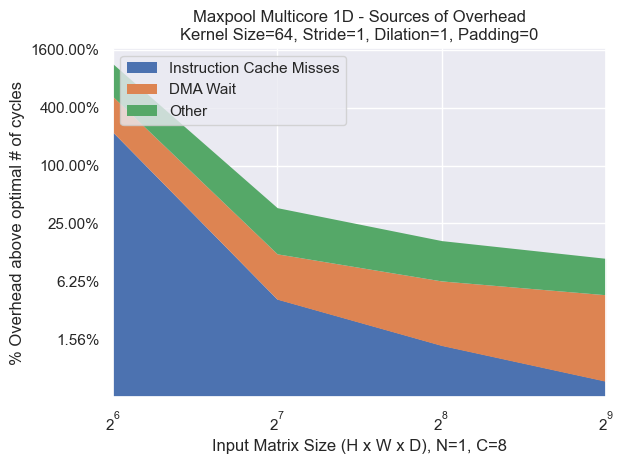

In [20]:
df_opt = df_a[(df_a["impl"] == "Multicore Optimized") & (df_a["stride"] == 1) & (df_a["dim"] == "1D")]

df_opt = get_augmented_df(df_opt, filter=False).dropna(axis=1)

df_opt["optimal_cycles"] = (df_opt["work"]/8)
df_opt["overhead_pct"] = df_opt["kernel_cycles"] / df_opt["optimal_cycles"]-1
df_opt["icache_overhead"] = df_opt["icache_miss"] / df_opt["optimal_cycles"]
df_opt["dma_overhead"] = df_opt["time_spent_waiting_in_barrier"] / df_opt["optimal_cycles"]
df_opt["rest"] = df_opt["overhead_pct"] - df_opt["icache_overhead"] - df_opt["dma_overhead"]

sns.set_theme()
ax = plt.gca()
plt.stackplot(df_opt["num_data_points"],
              df_opt["icache_overhead"], df_opt["dma_overhead"], df_opt["rest"],
              labels=["Instruction Cache Misses", "DMA Wait", "Other"],
              linewidth=0)

plt.legend(loc='upper left')
# ax.set_ylim(0.0001, None)
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
# ax.set_xticklabels(["8x8", "8x16", "16x16", "16x32", "32x32", "32x64", "64x64"])

ax.set_title("Maxpool Multicore 1D - Sources of Overhead\nKernel Size=64, Stride=1, Dilation=1, Padding=0")
ax.set_ylabel("% Overhead above optimal # of cycles")
ax.set_xlabel("Input Matrix Size (H x W x D), N=1, C=8")
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=2))

plt.margins(x=0)

plt.tight_layout()
plt.savefig("plots/overhead_1d_stride1.png")
plt.show()

sns.reset_defaults()

C:\Users\David\AppData\Local\Temp\ipykernel_22492\3409382994.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["fill", "4x4x4", "4x4x8", "4x8x8", "8x8x8", "8x8x16", "8x16x16", "16x16x16"])


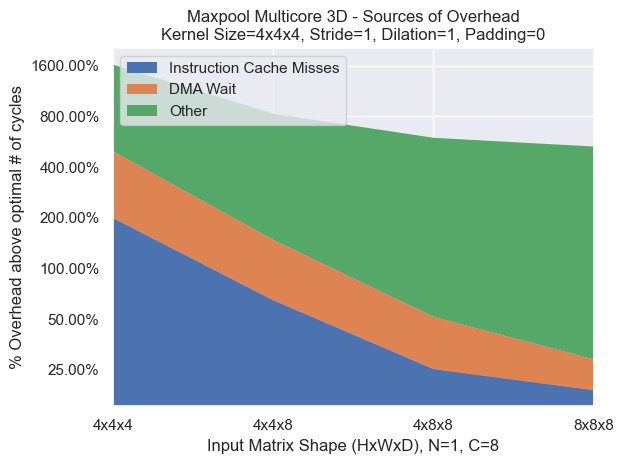

In [21]:
df_opt = df_a[(df_a["impl"] == "Multicore Optimized") & (df_a["stride"] == 1) & (df_a["dim"] == "3D")]

df_opt = get_augmented_df(df_opt, filter=False).dropna(axis=1)

df_opt["optimal_cycles"] = (df_opt["work"]/8)
df_opt["overhead_pct"] = df_opt["kernel_cycles"] / df_opt["optimal_cycles"]-1
df_opt["icache_overhead"] = df_opt["icache_miss"] / df_opt["optimal_cycles"]
df_opt["dma_overhead"] = df_opt["time_spent_waiting_in_barrier"] / df_opt["optimal_cycles"]
df_opt["rest"] = df_opt["overhead_pct"] - df_opt["icache_overhead"] - df_opt["dma_overhead"]

sns.set_theme()
ax = plt.gca()
plt.stackplot(df_opt["num_data_points"],
              df_opt["icache_overhead"], df_opt["dma_overhead"], df_opt["rest"],
              labels=["Instruction Cache Misses", "DMA Wait", "Other"],
              linewidth=0)

plt.legend(loc='upper left')
# ax.set_ylim(0.0001, None)
ax.set_xscale("log", base=2)
ax.set_yscale("log", base=2)
ax.set_xticklabels(["fill", "4x4x4", "4x4x8", "4x8x8", "8x8x8", "8x8x16", "8x16x16", "16x16x16"])

ax.set_title("Maxpool Multicore 3D - Sources of Overhead\nKernel Size=4x4x4, Stride=1, Dilation=1, Padding=0")
ax.set_ylabel("% Overhead above optimal # of cycles")
ax.set_xlabel("Input Matrix Shape (HxWxD), N=1, C=8")
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=2))

plt.margins(x=0)

plt.tight_layout()
plt.savefig("plots/overhead_3d_stride1.png")
plt.show()

sns.reset_defaults()

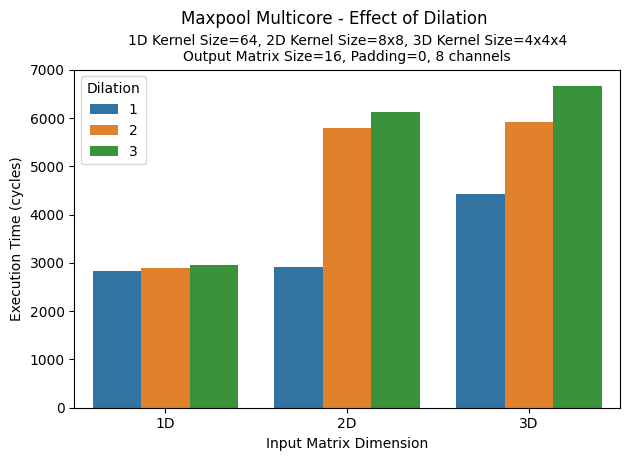

In [22]:
df_dilation = pd.DataFrame([['1D', '1', 2838.375],
                   ['1D', '2', 2901.125],
                   ['1D', '3', 2964.125],
                   ['2D', '1', 2919.25],
                   ['2D', '2', 5790.125],
                   ['2D', '3', 6132.125],
                   ['3D', '1', 4437.625],
                   ['3D', '2', 5912.125],
                   ['3D', '3', 6673.125]], columns=['Input Matrix Dimension', 'Dilation', 'Execution Time (cycles)']).set_index("Dilation")

# plot with seaborn barplot
g=sns.barplot(data=df_dilation, x='Input Matrix Dimension', y='Execution Time (cycles)', hue='Dilation')
# g.grid()
title = "Maxpool Multicore - Effect of Dilation"
subtitle = "1D Kernel Size=64, 2D Kernel Size=8x8, 3D Kernel Size=4x4x4\nOutput Matrix Size=16, Padding=0, 8 channels"

plt.suptitle(title, x=0.53, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

plt.tight_layout()
plt.savefig("plots/effect_of_dilation.png")
plt.show()

C:\Users\David\AppData\Local\Temp\ipykernel_22492\1304786002.py:16: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  g.set_ylim(0, 100000)


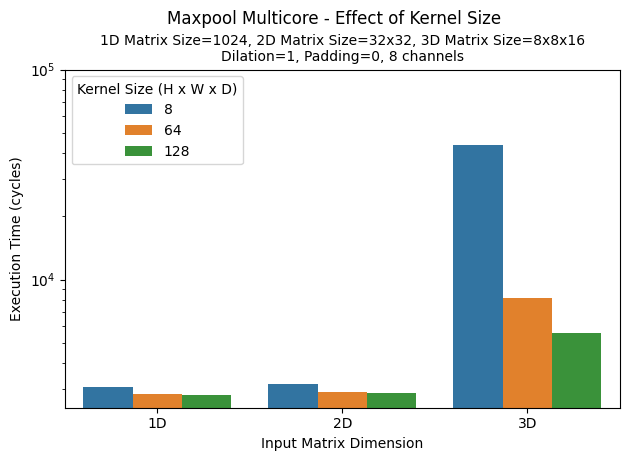

In [23]:
df_dilation = pd.DataFrame([['1D', '8', 3084.375],
                   ['1D', '64', 2838.375],
                   ['1D', '128', 2814.375],
                   ['2D', '8', 3170.25],
                   ['2D', '64', 2919.25],
                   ['2D', '128', 2889.25],
                   ['3D', '8', 43808.125],
                   ['3D', '64', 8171.625],
                   ['3D', '128', 5554.125]],
                   columns=['Input Matrix Dimension', 'Kernel Size (H x W x D)', 'Execution Time (cycles)']).set_index("Kernel Size (H x W x D)")

# plot with seaborn barplot
g=sns.barplot(data=df_dilation, x='Input Matrix Dimension', y='Execution Time (cycles)', hue='Kernel Size (H x W x D)')
# g.grid()
g.set_yscale("log", base=10)
g.set_ylim(0, 100000)
title = "Maxpool Multicore - Effect of Kernel Size"
subtitle = "1D Matrix Size=1024, 2D Matrix Size=32x32, 3D Matrix Size=8x8x16\nDilation=1, Padding=0, 8 channels"

plt.suptitle(title, x=0.53, y=0.95, fontsize=12)
g.set_title(subtitle, fontsize=10)

plt.tight_layout()
plt.savefig("plots/effect_of_kernel_size.png")
plt.show()

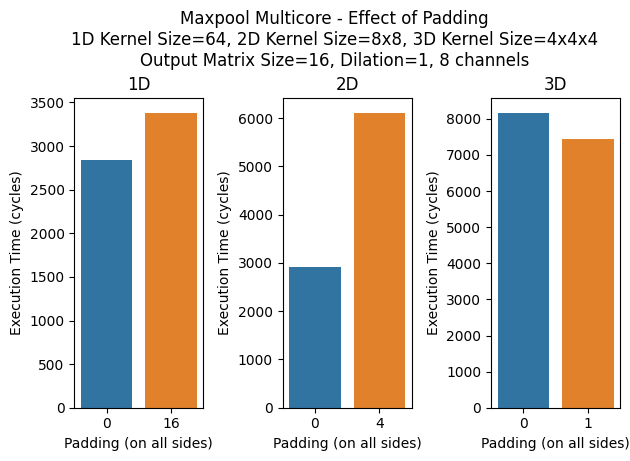

In [24]:
df_pads = pd.DataFrame([["1D", '0', 2838.375],
                   ["1D", '16', 3383.125],
                   ["2D", '0', 2919.25],
                   ["2D", '4', 6110.125],
                   ["3D", '0', 8171.625],
                   ["3D", '1', 7435.375]],
                   columns=["Dimension", 'Padding (on all sides)', 'Execution Time (cycles)']).set_index("Dimension")

df_pad1 = df_pads.loc["1D"].set_index("Padding (on all sides)")
df_pad2 = df_pads.loc["2D"].set_index("Padding (on all sides)")
df_pad3 = df_pads.loc["3D"].set_index("Padding (on all sides)")
# print(df_pad1.values)

datas = [df_pad1, df_pad2, df_pad3]

fig, ax = plt.subplots(1,3)

for i in range(3):

  # plot with seaborn barplot
  g=sns.barplot(ax=ax[i], x=datas[i].index, y=[datas[i].values[0][0], datas[i].values[1][0]], hue=datas[i].index)
  g.set_ylabel('Execution Time (cycles)')
  # g.grid()
  # g.set_yscale("log", base=10)
  # g.set_ylim(0, 100000)
  ax[i].set_title(f"{i+1}D")
  # subtitle = "1D Input Matrix Size=1024, 2D Input Matrix Size=32x32, 3D Input Matrix Size=8x8x16\nDilation=1, Padding=0, 8 channels"

fig.suptitle("Maxpool Multicore - Effect of Padding\n1D Kernel Size=64, 2D Kernel Size=8x8, 3D Kernel Size=4x4x4\nOutput Matrix Size=16, Dilation=1, 8 channels", x=0.53, y=0.95, fontsize=12)


# g.set_title(subtitle, fontsize=10)

plt.tight_layout()
# plt.subplots_adjust(wspace=0.7, right=1.2)
plt.savefig("plots/effect_of_padding.png")
plt.show()

In [25]:

all_df = get_augmented_df(df_a)
all_df = all_df[all_df["impl"]!="EXISTING"].dropna(axis=1)
all_df["optimal_cycles"] = ((all_df["work"]/all_df["impl"].map(lambda impl: 1 if "SINGLE_CORE" in impl else 8)) / (64/all_df["prec"]))
all_df["overhead_pct"] = all_df["kernel_cycles"] / all_df["optimal_cycles"]-1
all_df["icache_overhead"] = all_df["icache_miss"] / all_df["optimal_cycles"]
all_df["dma_overhead"] = all_df["time_spent_waiting_in_barrier"] / all_df["optimal_cycles"]

all_df["rest"] = all_df["overhead_pct"] - all_df["icache_overhead"] - all_df["dma_overhead"]
all_df

KeyError: 'prec'

In [ ]:
all_df = all_df[all_df["impl"].str.contains("MULTICORE")]
all_df['backward'] = all_df['direction'].map(lambda d: "b" in d)
all_df['training'] = all_df['direction'].map(lambda d: "t" in d)
all_df

,prec,impl,C,H,W,TILE_CI,direction,num_data_points,kernel_cycles,fpss_fpu_occupancy,...,performance,optimal_cycles,overhead_pct,icache_overhead,dma_overhead,rest,forward,eval,backward,training
0,32,MULTICORE_OPT,2,2,2,2,be,8,446,0.170787,...,0.282511,7.875,55.634921,11.809524,23.238095,20.587302,False,True,True,False
1,32,MULTICORE_OPT,4,2,2,4,be,16,462,0.164859,...,0.545455,15.750,28.333333,5.206349,11.619048,11.507937,False,True,True,False
2,32,MULTICORE_OPT,4,4,2,4,be,32,462,0.208243,...,0.718615,20.750,21.265060,3.951807,8.819277,8.493976,False,True,True,False
3,32,MULTICORE_OPT,4,4,4,4,be,64,494,0.275862,...,0.995951,30.750,15.065041,2.666667,5.951220,6.447154,False,True,True,False
4,32,MULTICORE_OPT,8,4,4,8,be,128,514,0.265107,...,1.914397,61.500,7.357724,1.333333,2.943089,3.081301,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,64,MULTICORE_OPT,32,16,16,32,ft,8192,9400,0.511757,...,3.782128,4444.000,1.115212,0.188569,0.419442,0.507201,True,False,False,True
147,64,MULTICORE_OPT,32,32,16,32,ft,16384,16154,0.555377,...,4.229293,8540.000,0.891569,0.109719,0.385363,0.396487,True,False,False,True
148,64,MULTICORE_OPT,32,32,32,32,ft,32768,28839,0.599660,...,4.641492,16732.000,0.723584,0.064427,0.335824,0.323333,True,False,False,True
149,64,MULTICORE_OPT,16,64,64,16,ft,65536,50888,0.654961,...,5.178745,32942.000,0.544776,0.031024,0.382065,0.131686,True,False,False,True


Text(0.5, 0.98, 'Batchnorm: Execution overhead above optimal cycle count by direction and inference mode')

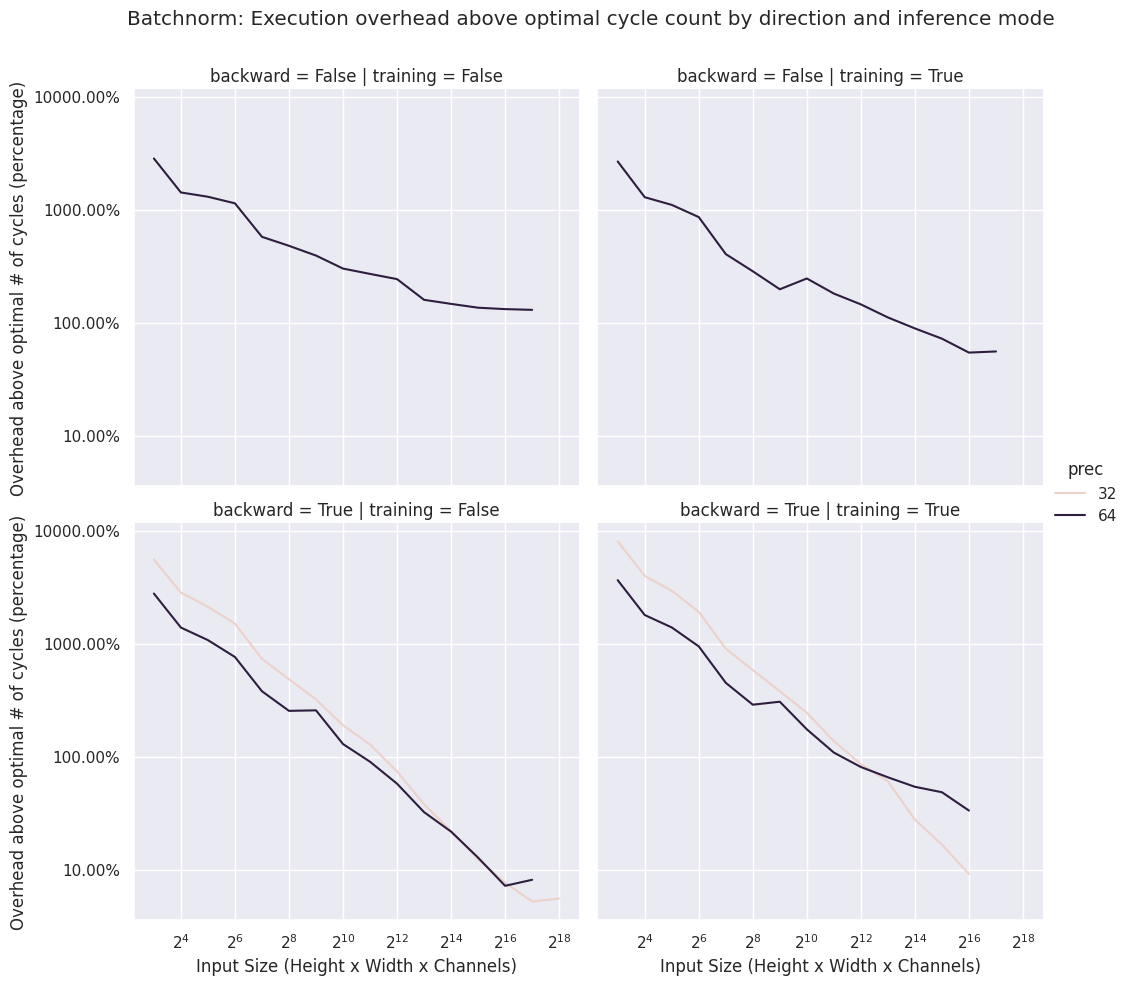

In [ ]:
fg = sns.relplot(all_df, x="num_data_points", y="overhead_pct", kind="line",row="backward", col="training", hue="prec", hue_kws={})
fg.set(yscale="log", xscale="log")


# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
# ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=2))
for ax in fg.axes.flat:
    ax.set_xscale('log', base=2)
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0, decimals=2))
    # ax.xaxis.set_major_formatter(lambda x, p: f'{x}: Is that your best')
fg.set_ylabels("Overhead above optimal # of cycles (percentage)")
fg.set_xlabels("Input Size (Height x Width x Channels)")
fg.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
fg.fig.suptitle('Batchnorm: Execution overhead above optimal cycle count by direction and inference mode')

In [ ]:
# gb = all_df.groupby(["direction", "num_data_points", "impl"])
indexed = all_df.set_index(["direction", "num_data_points"])
indexed[indexed.index.get_level_values("impl")=="SINGLE_CORE_OPT"]["kernel_cycles"] /indexed[indexed.index.get_level_values("impl")=="MULTICORE_OPT"]["kernel_cycles"]

KeyError: 'Level impl not found'